In [ ]:
# Import all required libraries
import warnings
import pathlib
import sys

# Add src directory to path for helper functions
repo_dir = pathlib.Path().cwd().parent
src_dir = repo_dir / "src"
sys.path.insert(0, str(src_dir))

# Data manipulation and scientific computing
import pandas as pd
import numpy as np
import scipy.sparse

# Machine learning and neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Progress bars and utilities
from tqdm import tqdm

# Domain-specific libraries
import hetmatpy.matrix

# Import helper functions from src package
from models import EdgePredictionNN
from data_processing import prepare_edge_prediction_data, load_permutation_data, load_all_permutations
from training import train_edge_prediction_model, train_across_permutations
from visualization import (
    plot_training_history, 
    evaluate_model_performance, 
    create_probability_heatmap,
    plot_permutation_comparison
)

Repository directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn
Data directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data
Permutations directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data/permutations
Available permutations: ['000.hetmat', '000.hetmat.bak', '001.hetmat']


In [ ]:
# Parameters for papermill
# Default parameter values - can be overridden by papermill
permutations_subdirectory = "permutations"  # Default: use 'permutations' (local generated)
                                           # Example alternatives: 'hetio200' (downloaded), 'permutations/hetio200'

# Validation
if not isinstance(permutations_subdirectory, str):
    raise ValueError(f"permutations_subdirectory must be a string, got: {permutations_subdirectory}")

print(f"Using permutations subdirectory: {permutations_subdirectory}")

In [ ]:
# Set up paths for data access using parameterized directory
repo_dir = pathlib.Path().cwd().parent
data_dir = repo_dir / 'data'

# Use the parameterized permutations subdirectory
if '/' in permutations_subdirectory:
    # Handle nested paths like 'permutations/hetio200'
    permutations_dir = data_dir / permutations_subdirectory
else:
    # Handle simple paths like 'permutations' or 'hetio200'
    permutations_dir = data_dir / 'permutations' / permutations_subdirectory

print(f"Repository directory: {repo_dir}")
print(f"Data directory: {data_dir}")
print(f"Permutations directory: {permutations_dir}")

# List available permutations
if permutations_dir.exists():
    available_permutations = [p.name for p in permutations_dir.iterdir() if p.is_dir()]
    print(f"Available permutations: {available_permutations}")
else:
    print(f"⚠️ Permutations directory not found: {permutations_dir}")
    available_permutations = []

In [ ]:
# Load data from the first available permutation
if available_permutations:
    # Use the first permutation as an example
    example_permutation = available_permutations[0]
    print(f"Loading example data from: {example_permutation}")
    
    # Load the data using helper function from data_processing
    perm_data = load_permutation_data(example_permutation, permutations_dir)
    
    # Access the loaded data
    aeg_edges = perm_data['aeg_edges']
    anatomy_nodes = perm_data['anatomy_nodes']
    gene_nodes = perm_data['gene_nodes']
    
    print("\n" + "="*50)
    print("DATA SUMMARY")
    print("="*50)
    print(f"AeG edges matrix shape: {aeg_edges.shape}")
    print(f"AeG edges density: {aeg_edges.nnz / (aeg_edges.shape[0] * aeg_edges.shape[1]):.6f}")
    print(f"Number of Anatomy nodes: {len(anatomy_nodes)}")
    print(f"Number of Gene nodes: {len(gene_nodes)}")
    
    # Show sample data
    print("\nSample Anatomy nodes:")
    print(anatomy_nodes.head())
    
    print("\nSample Gene nodes:")
    print(gene_nodes.head())
    
    # Load all permutations for later use
    print("\nLoading all available permutations...")
    all_perm_data = load_all_permutations(available_permutations, permutations_dir)
    print(f"\nSuccessfully loaded {len(all_perm_data)} permutations: {list(all_perm_data.keys())}")
    
else:
    print("No permutations found in the permutations directory!")

Loading example data from: 000.hetmat
Loading data from permutation: 000.hetmat
Permutation path: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data/permutations/000.hetmat
Loaded AeG edges: (402, 20945) matrix with 526407 non-zero entries
Loaded Anatomy nodes: 402 nodes
Anatomy columns: ['position', 'identifier', 'name']
Loaded Gene nodes: 20945 nodes
Gene columns: ['position', 'identifier', 'name']

DATA SUMMARY
AeG edges matrix shape: (402, 20945)
AeG edges density: 0.062519
Number of Anatomy nodes: 402
Number of Gene nodes: 20945

Sample Anatomy nodes:
   position      identifier                       name
0         0  UBERON:0000002             uterine cervix
1         1  UBERON:0000004                       nose
2         2  UBERON:0000006        islet of Langerhans
3         3  UBERON:0000007            pituitary gland
4         4  UBERON:0000010  peripheral nervous system

Sample Gene nodes:
   position  identifier      name
0

In [36]:
# Neural Network and Machine Learning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print("Neural network libraries imported successfully!")

Neural network libraries imported successfully!


In [40]:
# Train the neural network on a single permutation
print("="*60)
print("TRAINING EDGE PREDICTION NEURAL NETWORK")
print("="*60)

# Use the first permutation for training
training_permutation = list(all_perm_data.keys())[0]
print(f"Training on permutation: {training_permutation}")

# Prepare training data
print("\nPreparing training data...")
features, labels = prepare_edge_prediction_data(
    all_perm_data[training_permutation], 
    sample_negative_ratio=1.0
)

print(f"Feature matrix shape: {features.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Positive examples: {np.sum(labels == 1)}")
print(f"Negative examples: {np.sum(labels == 0)}")

# Train the model
print("\nTraining neural network...")
model, train_history, test_metrics = train_edge_prediction_model(
    features, labels, 
    epochs=100,
    batch_size=512,
    learning_rate=0.001
)

print(f"\nTraining completed!")
print(f"Final Test AUC: {test_metrics['auc']:.4f}")
print(f"Final Test Average Precision: {test_metrics['average_precision']:.4f}")

TRAINING EDGE PREDICTION NEURAL NETWORK
Training on permutation: 000.hetmat

Preparing training data...
Anatomy degree range: 0 - 15036
Gene degree range: 0 - 98
Number of positive examples (existing edges): 526407
Number of negative examples (non-existing edges): 526407
Feature matrix shape: (1052814, 2)
Labels shape: (1052814,)
Positive examples: 526407
Negative examples: 526407

Training neural network...
Training on 842251 samples, testing on 210563 samples
Feature shapes: (842251, 2), Labels shape: (842251,)
Number of negative examples (non-existing edges): 526407
Feature matrix shape: (1052814, 2)
Labels shape: (1052814,)
Positive examples: 526407
Negative examples: 526407

Training neural network...
Training on 842251 samples, testing on 210563 samples
Feature shapes: (842251, 2), Labels shape: (842251,)


Training:  20%|██        | 20/100 [01:19<05:21,  4.02s/it]

Epoch 20/100: Train Loss: 0.1300, Val Loss: 0.1286, Val AUC: 0.9875


Training:  40%|████      | 40/100 [02:40<04:01,  4.02s/it]

Epoch 40/100: Train Loss: 0.1295, Val Loss: 0.1285, Val AUC: 0.9875


Training:  60%|██████    | 60/100 [04:02<02:45,  4.14s/it]

Epoch 60/100: Train Loss: 0.1297, Val Loss: 0.1286, Val AUC: 0.9875


Training:  80%|████████  | 80/100 [05:24<01:21,  4.08s/it]

Epoch 80/100: Train Loss: 0.1296, Val Loss: 0.1295, Val AUC: 0.9875


Training: 100%|██████████| 100/100 [06:45<00:00,  4.06s/it]

Epoch 100/100: Train Loss: 0.1298, Val Loss: 0.1283, Val AUC: 0.9875

Training completed!
Final Test AUC: 0.9875
Final Test Average Precision: 0.9847


Plotting training history...


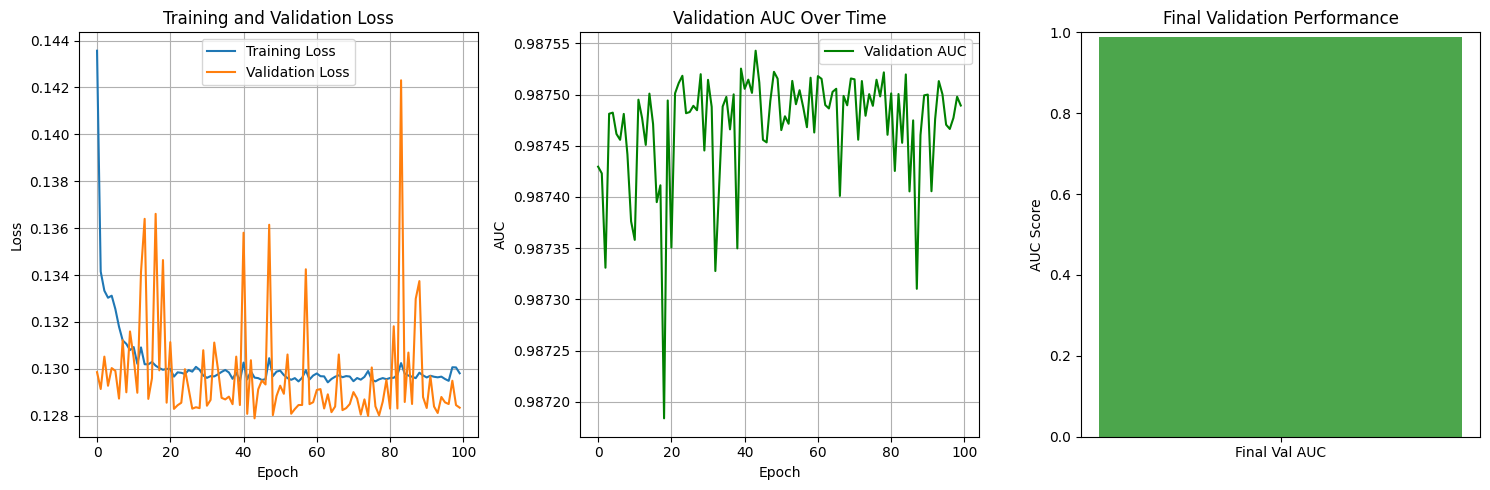


Evaluating model performance...
Test AUC: 0.9875
Average Precision: 0.9847


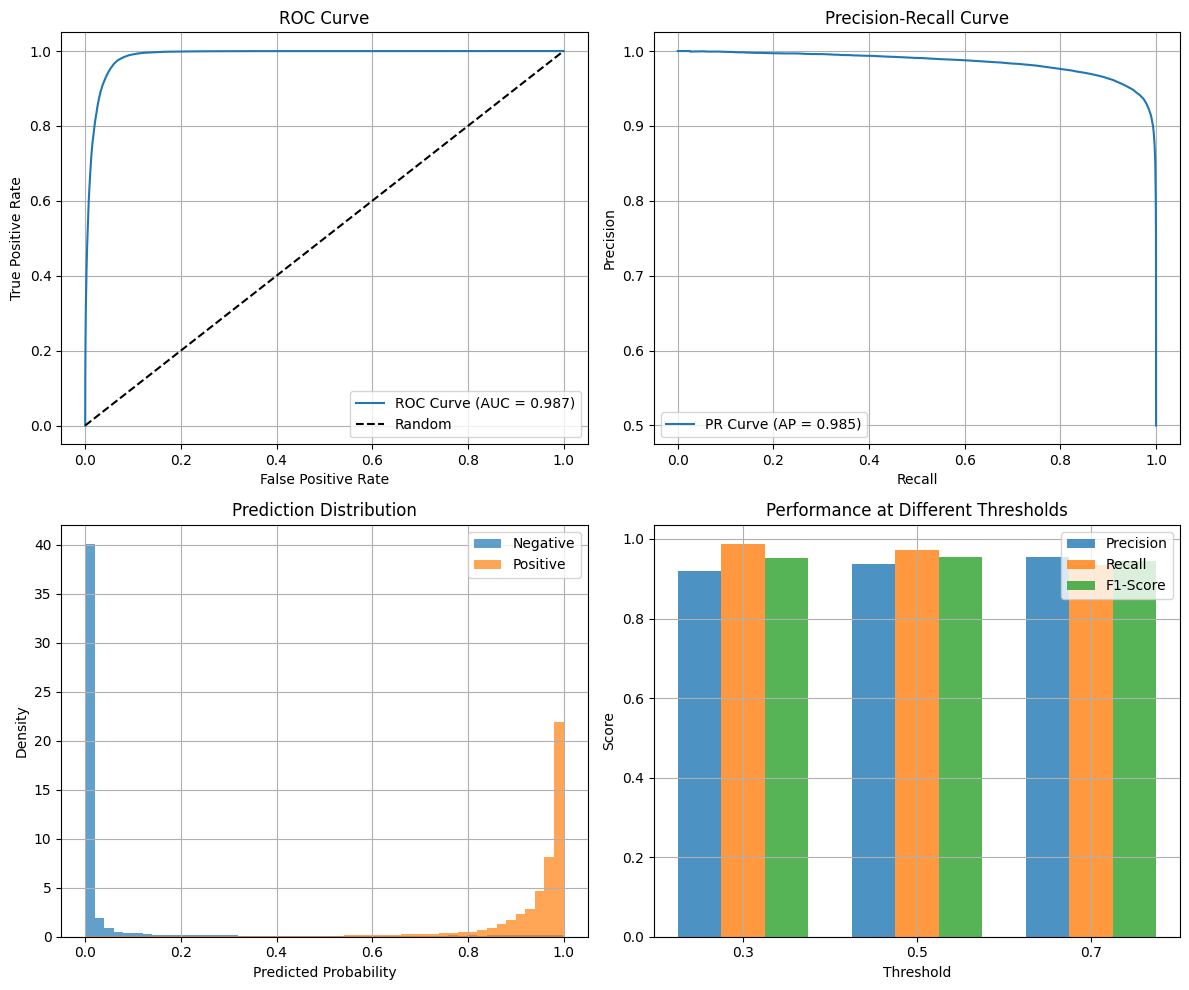

In [41]:
# Visualize training results
print("Plotting training history...")
plot_training_history(train_history)

print("\nEvaluating model performance...")
threshold_results = evaluate_model_performance(test_metrics)


DETAILED PROBABILITY ANALYSIS


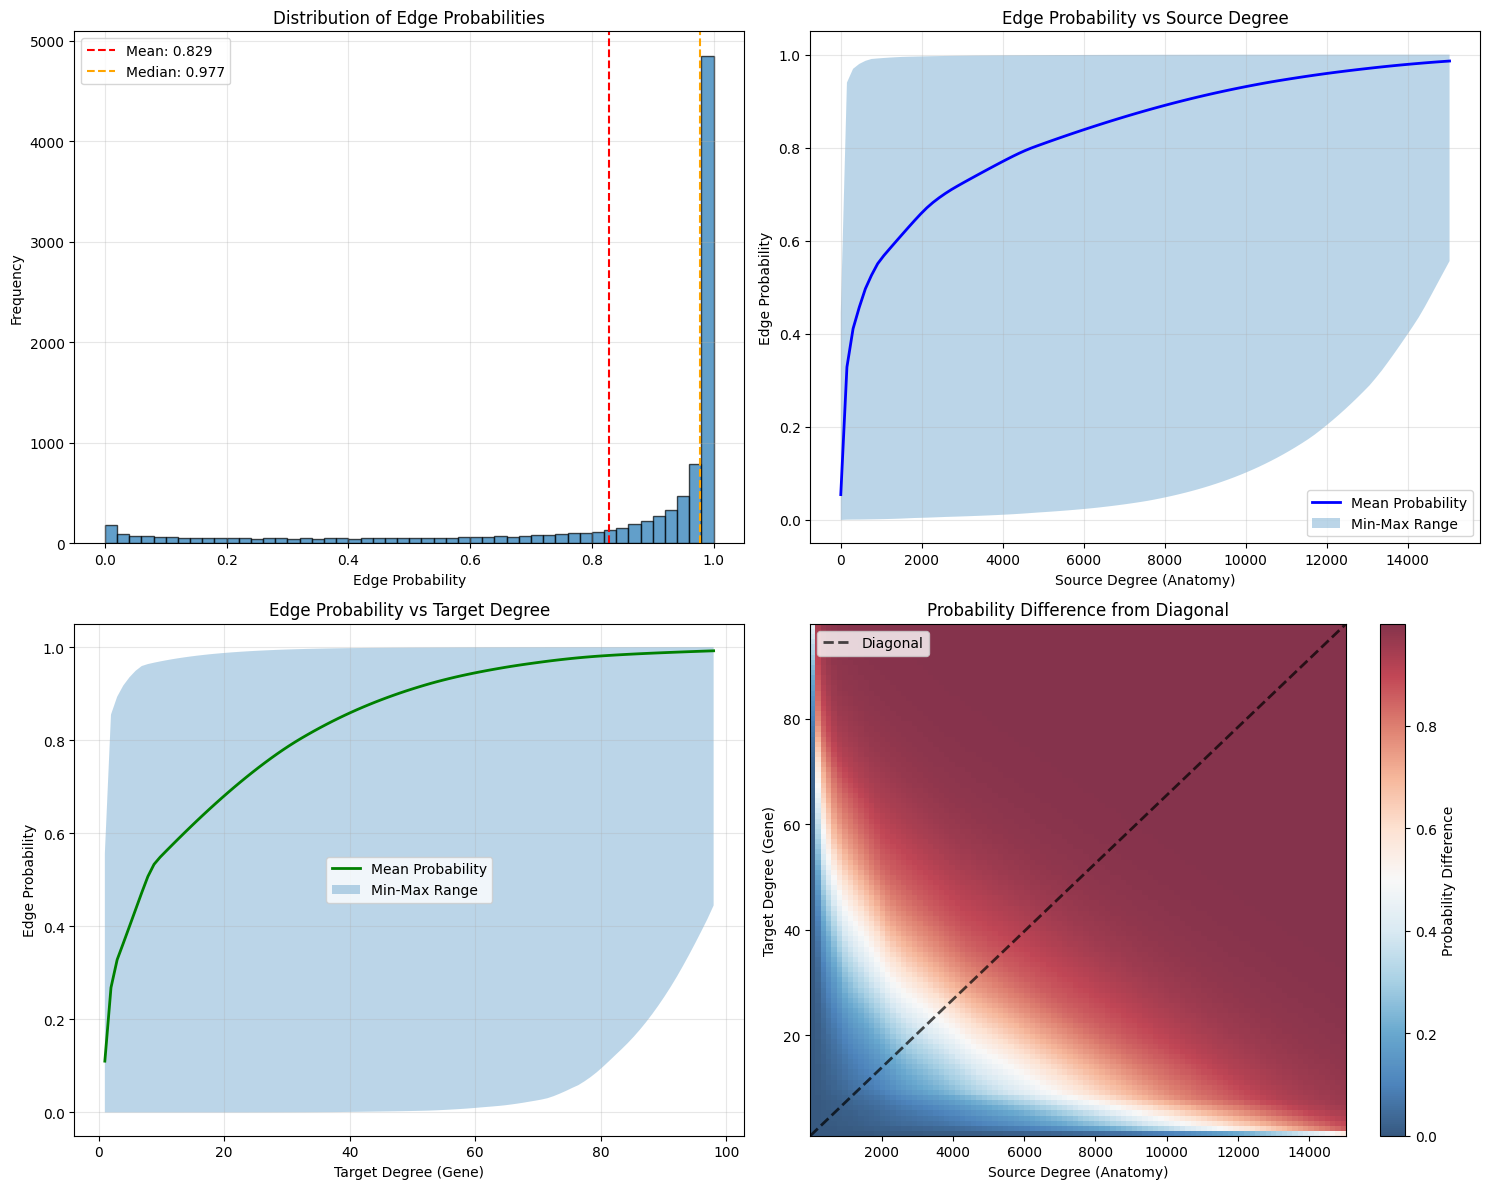


Summary Statistics:
Overall probability range: 0.0000 - 1.0000
Mean probability: 0.8286 ± 0.2800
Median probability: 0.9771

High probability regions (>90th percentile, >0.999):
  Source degree: 15036.0, Target degree: 61.7, Probability: 0.9995
  Source degree: 14732.3, Target degree: 62.7, Probability: 0.9995
  Source degree: 14884.1, Target degree: 62.7, Probability: 0.9995
  Source degree: 15036.0, Target degree: 62.7, Probability: 0.9995
  Source degree: 14580.4, Target degree: 63.7, Probability: 0.9995

Low probability regions (<10th percentile, <0.312):
  Source degree: 1.0, Target degree: 1.0, Probability: 0.0000
  Source degree: 152.9, Target degree: 1.0, Probability: 0.0007
  Source degree: 304.7, Target degree: 1.0, Probability: 0.0009
  Source degree: 456.6, Target degree: 1.0, Probability: 0.0010
  Source degree: 608.5, Target degree: 1.0, Probability: 0.0012


In [43]:
# Additional analysis: Probability patterns across degree ranges
print("\n" + "="*60)
print("DETAILED PROBABILITY ANALYSIS")
print("="*60)

# Create more detailed analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Probability distribution histogram
axes[0, 0].hist(probability_matrix.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Edge Probability')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Edge Probabilities')
axes[0, 0].grid(True, alpha=0.3)

# Add summary statistics
mean_prob = probability_matrix.mean()
median_prob = np.median(probability_matrix)
axes[0, 0].axvline(mean_prob, color='red', linestyle='--', label=f'Mean: {mean_prob:.3f}')
axes[0, 0].axvline(median_prob, color='orange', linestyle='--', label=f'Median: {median_prob:.3f}')
axes[0, 0].legend()

# 2. Probability vs Source Degree (averaged over target degrees)
mean_prob_by_source = probability_matrix.mean(axis=0)  # Average over target degrees
axes[0, 1].plot(source_degrees, mean_prob_by_source, 'b-', linewidth=2, label='Mean Probability')
axes[0, 1].fill_between(source_degrees, 
                       probability_matrix.min(axis=0), 
                       probability_matrix.max(axis=0), 
                       alpha=0.3, label='Min-Max Range')
axes[0, 1].set_xlabel('Source Degree (Anatomy)')
axes[0, 1].set_ylabel('Edge Probability')
axes[0, 1].set_title('Edge Probability vs Source Degree')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Probability vs Target Degree (averaged over source degrees)
mean_prob_by_target = probability_matrix.mean(axis=1)  # Average over source degrees
axes[1, 0].plot(target_degrees, mean_prob_by_target, 'g-', linewidth=2, label='Mean Probability')
axes[1, 0].fill_between(target_degrees, 
                       probability_matrix.min(axis=1), 
                       probability_matrix.max(axis=1), 
                       alpha=0.3, label='Min-Max Range')
axes[1, 0].set_xlabel('Target Degree (Gene)')
axes[1, 0].set_ylabel('Edge Probability')
axes[1, 0].set_title('Edge Probability vs Target Degree')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Difference from diagonal (source degree = target degree)
# Create a heatmap showing how probability differs from the diagonal
diagonal_prob = np.diag(probability_matrix)
source_mesh, target_mesh = np.meshgrid(source_degrees, target_degrees)

# Calculate difference from diagonal expectation
diagonal_interp = np.interp(target_mesh, source_degrees, diagonal_prob)
prob_diff = probability_matrix - diagonal_interp

im = axes[1, 1].imshow(prob_diff, 
                      extent=[source_degrees.min(), source_degrees.max(), 
                             target_degrees.min(), target_degrees.max()],
                      origin='lower', aspect='auto', cmap='RdBu_r', alpha=0.8)

axes[1, 1].set_xlabel('Source Degree (Anatomy)')
axes[1, 1].set_ylabel('Target Degree (Gene)')
axes[1, 1].set_title('Probability Difference from Diagonal')

# Add diagonal line
axes[1, 1].plot([source_degrees.min(), source_degrees.max()], 
               [target_degrees.min(), target_degrees.max()], 
               'k--', linewidth=2, alpha=0.7, label='Diagonal')
axes[1, 1].legend()

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1, 1])
cbar.set_label('Probability Difference')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Overall probability range: {probability_matrix.min():.4f} - {probability_matrix.max():.4f}")
print(f"Mean probability: {probability_matrix.mean():.4f} ± {probability_matrix.std():.4f}")
print(f"Median probability: {np.median(probability_matrix):.4f}")

# Find high and low probability regions
high_prob_threshold = np.percentile(probability_matrix, 90)
low_prob_threshold = np.percentile(probability_matrix, 10)

print(f"\nHigh probability regions (>90th percentile, >{high_prob_threshold:.3f}):")
high_prob_mask = probability_matrix > high_prob_threshold
high_prob_indices = np.where(high_prob_mask)
if len(high_prob_indices[0]) > 0:
    for i in range(min(5, len(high_prob_indices[0]))):  # Show first 5
        source_idx, target_idx = high_prob_indices[1][i], high_prob_indices[0][i]
        prob_val = probability_matrix[target_idx, source_idx]
        print(f"  Source degree: {source_degrees[source_idx]:.1f}, Target degree: {target_degrees[target_idx]:.1f}, Probability: {prob_val:.4f}")

print(f"\nLow probability regions (<10th percentile, <{low_prob_threshold:.3f}):")
low_prob_mask = probability_matrix < low_prob_threshold
low_prob_indices = np.where(low_prob_mask)
if len(low_prob_indices[0]) > 0:
    for i in range(min(5, len(low_prob_indices[0]))):  # Show first 5
        source_idx, target_idx = low_prob_indices[1][i], low_prob_indices[0][i]
        prob_val = probability_matrix[target_idx, source_idx]
        print(f"  Source degree: {source_degrees[source_idx]:.1f}, Target degree: {target_degrees[target_idx]:.1f}, Probability: {prob_val:.4f}")

TRAINING ACROSS ALL PERMUTATIONS

Training on permutation: 000.hetmat
----------------------------------------
Anatomy degree range: 0 - 15036
Gene degree range: 0 - 98
Number of positive examples (existing edges): 526407
Number of negative examples (non-existing edges): 526407
Training on 842251 samples, testing on 210563 samples
Feature shapes: (842251, 2), Labels shape: (842251,)
Number of negative examples (non-existing edges): 526407
Training on 842251 samples, testing on 210563 samples
Feature shapes: (842251, 2), Labels shape: (842251,)


Training: 100%|██████████| 20/20 [01:20<00:00,  4.05s/it]

Epoch 20/20: Train Loss: 0.1313, Val Loss: 0.1296, Val AUC: 0.9877
✓ 000.hetmat: AUC = 0.9877, AP = 0.9851

Training on permutation: 001.hetmat
----------------------------------------
Anatomy degree range: 0 - 15036
Gene degree range: 0 - 98
Number of positive examples (existing edges): 526407


Number of negative examples (non-existing edges): 526407
Training on 842251 samples, testing on 210563 samples
Feature shapes: (842251, 2), Labels shape: (842251,)
Training on 842251 samples, testing on 210563 samples
Feature shapes: (842251, 2), Labels shape: (842251,)


Training: 100%|██████████| 20/20 [01:21<00:00,  4.09s/it]

Epoch 20/20: Train Loss: 0.1319, Val Loss: 0.1456, Val AUC: 0.9876
✓ 001.hetmat: AUC = 0.9876, AP = 0.9851


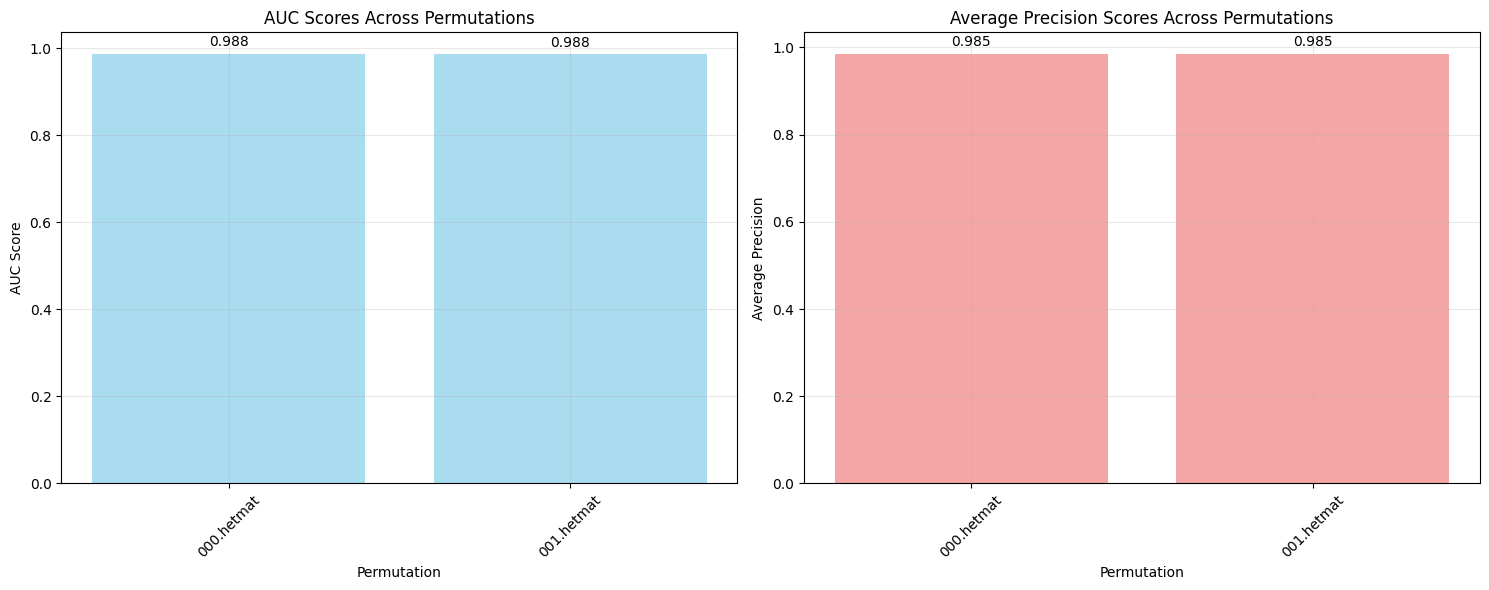


Summary Statistics:
Mean AUC: 0.9876 ± 0.0001
Mean AP: 0.9851 ± 0.0000
Min AUC: 0.9876, Max AUC: 0.9877
Min AP: 0.9851, Max AP: 0.9851
NEURAL NETWORK SETUP COMPLETE!
✓ Data loading functions defined
✓ Neural network architecture implemented
✓ Training pipeline established
✓ Evaluation and visualization tools ready
✓ Single permutation model trained

To train across all permutations, uncomment the lines above.
The model predicts edge probability based on source and target node degrees.


In [45]:
# Optional: Train across all permutations (uncomment to run)
# This will take longer as it trains a separate model for each permutation

all_results = train_across_permutations(all_perm_data, epochs=20)
plot_permutation_comparison(all_results)

print("="*60)
print("NEURAL NETWORK SETUP COMPLETE!")
print("="*60)
print("✓ Data loading functions defined")
print("✓ Neural network architecture implemented")
print("✓ Training pipeline established")
print("✓ Evaluation and visualization tools ready")
print("✓ Single permutation model trained")
print("\nTo train across all permutations, uncomment the lines above.")
print("The model predicts edge probability based on source and target node degrees.")